### **Project PCD 2025 Kelompok 18**
#### **Klasifikasi Kangker Kulit Jinak Dan Ganas**

Zainul Majdi (F1D02310028)

Mustofa Arif (F1D02310083)

Apriesna Zulhan (F1D02310100)

Lalu Maulana Rizki Hidayat (F1D02310118)

### **Project Overview**

### **Import Library**

In [66]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

### **Data Loading**

In [67]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset"):
    sub_folder_files = os.listdir(os.path.join("dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

Jumlah data per kelas: Counter({'benign': 360, 'malignant': 289})


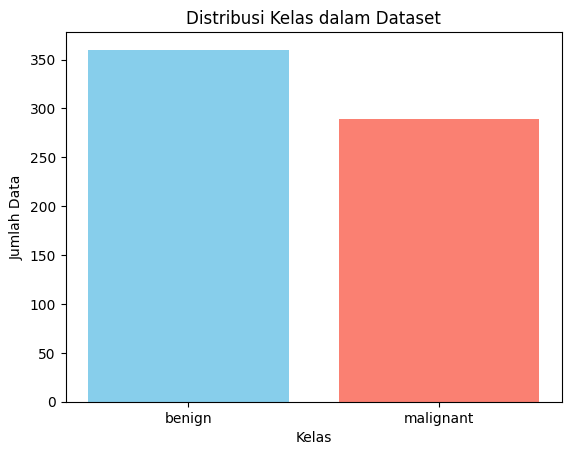

In [68]:
class_count = Counter(labels)

print("Jumlah data per kelas:", class_count)

label_names = list(class_count.keys())
jumlah = list(class_count.values())

plt.bar(label_names, jumlah, color=['skyblue', 'salmon'])
plt.title("Distribusi Kelas dalam Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

### **Data Preparation**

#### **Define Preprocessing Function**

In [69]:
def resize(img, new_width, new_height):
    h, w = img.shape
    resized = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(j * w / new_width)
            y = int(i * h / new_height)
            resized[i, j] = img[y, x]
    
    return resized

def median_filter(image,baris,kolom):
    tengah = int(baris*kolom/2)
    hasil = np.zeros(image.shape)
    _baris = int((baris-1)/2)
    _kolom = int((kolom-1)/2)
    _image = np.pad(image,((_baris,_baris),(_kolom,_kolom)),mode='edge')
    for i in range (hasil.shape[0]):
        for j in range (hasil.shape[1]):
            Median = np.zeros(baris*kolom)
            m=0
            for k in range (i,i+baris):
                for l in range (j,j+kolom):
                    Median[m]=_image[k,l]
                    m+=1
            Median.sort()
            a = Median[tengah]
            b = Median[tengah-1]
            _Median = int(a+b)/2
            hasil[i,j] =_Median
    return hasil

def normalize_min_max(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val == min_val:
        return np.zeros_like(image, dtype=np.uint8)  # atau isi dengan nilai tetap
    norm = (image - min_val) / (max_val - min_val)
    return (norm * 255).astype(np.uint8)

def threshold(image, nilai_ambang):
    tinggi_gambar, lebar_gambar = image.shape
    hasil_biner = np.zeros((tinggi_gambar, lebar_gambar), dtype=np.uint8)

    for baris in range(tinggi_gambar):
        for kolom in range(lebar_gambar):
            if image[baris, kolom] <= nilai_ambang:
                hasil_biner[baris, kolom] = 255
            else:
                hasil_biner[baris, kolom] = 0

    return hasil_biner

def dilasi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.any(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def erosi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.all(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def opening(gambar, kernel):
    eroded = erosi(gambar, kernel)
    opened = dilasi(eroded, kernel)
    return opened.astype(np.uint8)

def closing(gambar, kernel):
    dilated = dilasi(gambar, kernel)
    closed = erosi(dilated, kernel)
    return closed.astype(np.uint8)

#### **Preprocessing**

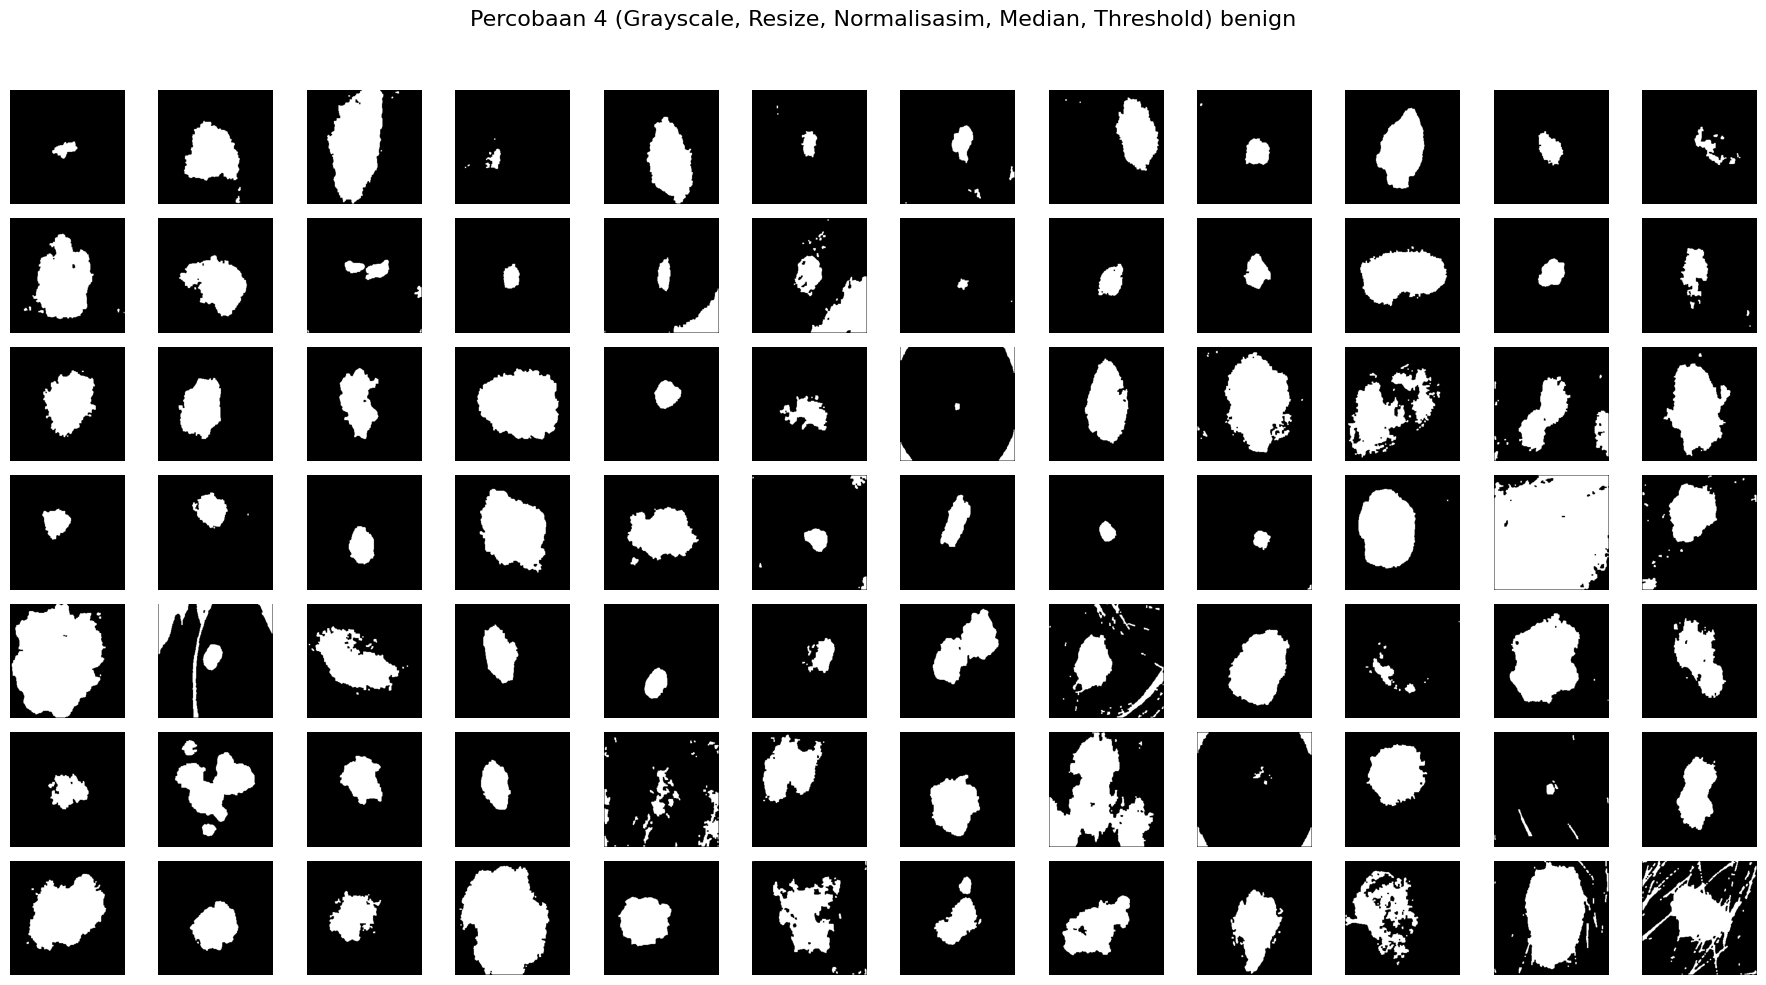

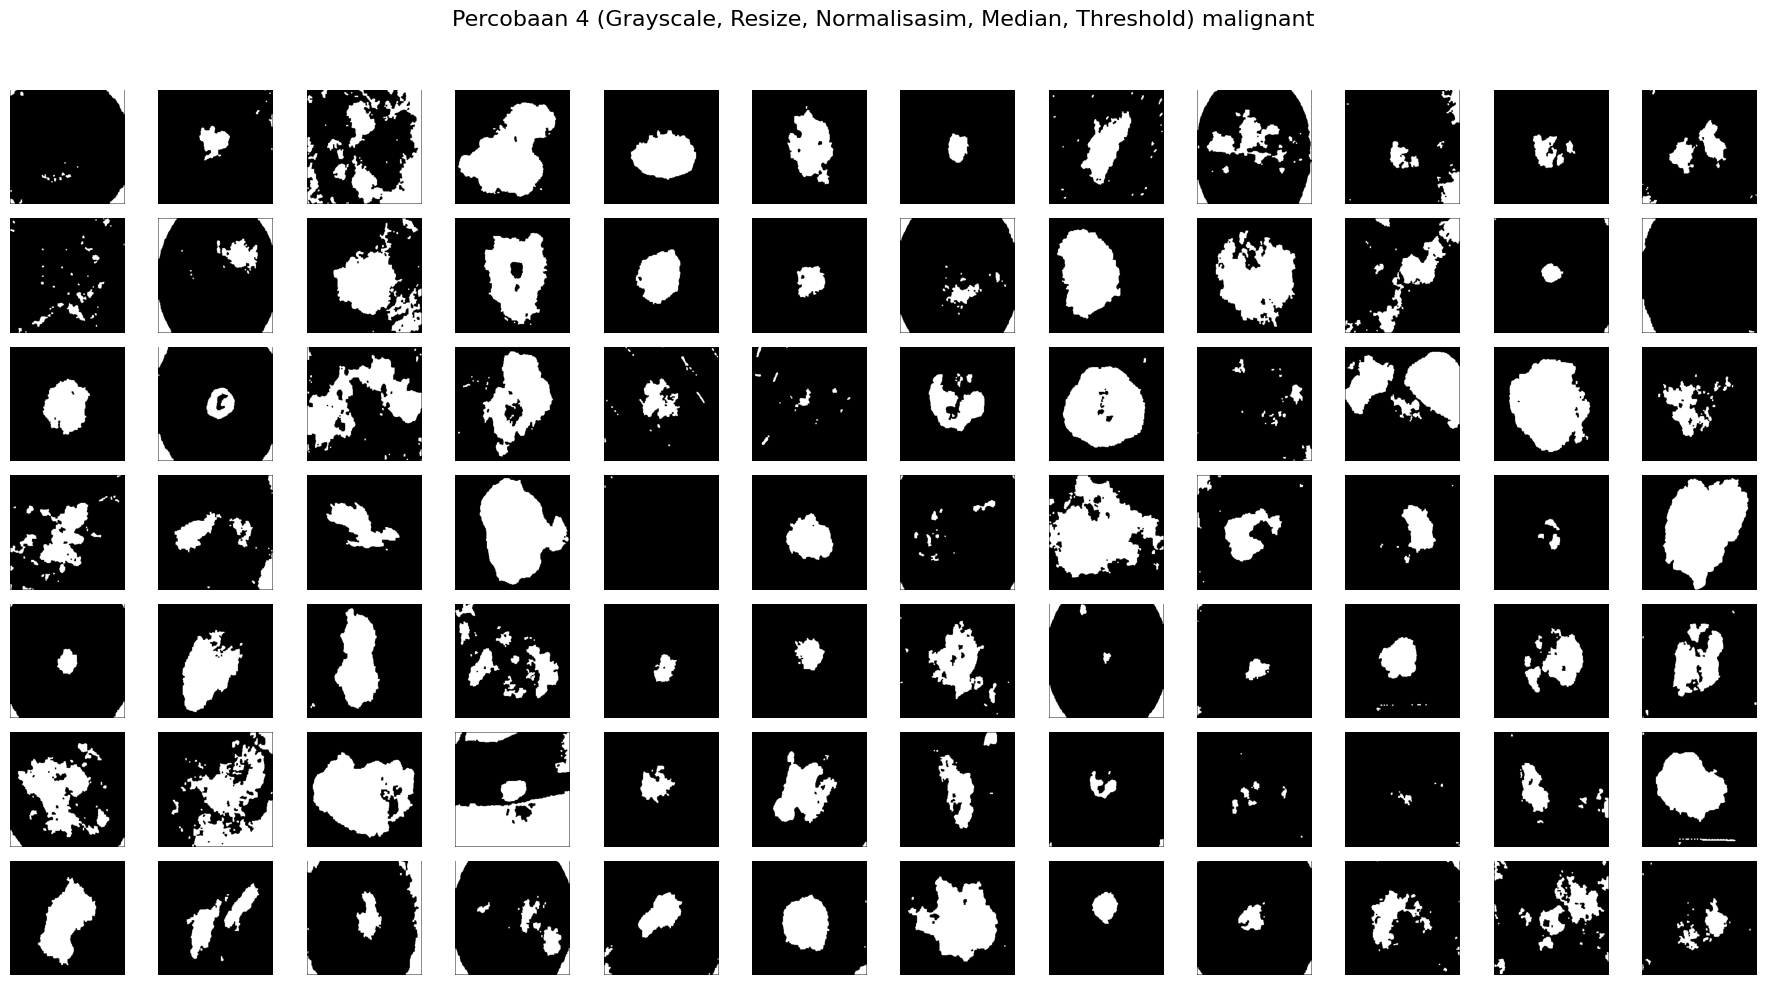

In [70]:
def percobaan_4(img):
    img_rsz = resize(img, 256, 256)
    img_norm = normalize_min_max(img_rsz)
    img_median = median_filter(img_norm, 3, 3)
    img_thresh = threshold(img_median, 127)  # Thresholding dengan nilai ambang 127
    img_open = opening(img_thresh, np.ones((3, 3)))
    img_close = closing(img_open, np.ones((3, 3)))

    return img_close

dataPreprocessed = [percobaan_4(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 4 (Grayscale, Resize, Normalisasim, Median, Threshold) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()
    

#### **Feature Extraction**

In [71]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [72]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [73]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [74]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [75]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [76]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [77]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [78]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [79]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [80]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [81]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [82]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [83]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [84]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [85]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [86]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [87]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

#### **Write the extraction's results to CSV**

In [97]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_4.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_4.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1.jpg,benign,83.671875,168.0,111.562500,130.0,0.998713,0.997416,0.998284,0.998001,...,0.963941,0.963526,0.982023,0.981297,0.981805,0.981594,0.962535,0.925065,0.950047,0.942015
1,10.jpg,benign,364.570312,526.0,326.718750,542.0,0.994393,0.991911,0.994976,0.991665,...,0.702227,0.698063,0.837646,0.835646,0.837990,0.835501,0.980850,0.972455,0.982838,0.971617
2,1003.jpg,benign,587.695312,812.0,370.546875,742.0,0.990962,0.987513,0.994302,0.988589,...,0.549106,0.542626,0.738793,0.735918,0.741017,0.736632,0.979700,0.972007,0.987201,0.974420
3,1006.jpg,benign,151.406250,228.0,131.484375,222.0,0.997672,0.996494,0.997978,0.996586,...,0.971683,0.970197,0.985585,0.984939,0.985740,0.984986,0.911464,0.867189,0.923113,0.870684
4,1013.jpg,benign,392.460938,488.0,264.960938,514.0,0.993965,0.992495,0.995925,0.992095,...,0.679841,0.675123,0.823347,0.821898,0.824525,0.821658,0.980906,0.976328,0.987109,0.975067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,953.jpg,malignant,882.539062,1290.0,703.242188,1190.0,0.986428,0.980162,0.989185,0.981700,...,0.539791,0.531676,0.732872,0.728146,0.734705,0.729161,0.969807,0.955949,0.975941,0.959364
645,985.jpg,malignant,571.757812,858.0,513.984375,796.0,0.991207,0.986805,0.992096,0.987759,...,0.766875,0.761873,0.875215,0.872321,0.875714,0.872854,0.960970,0.941624,0.964913,0.945843
646,992.jpg,malignant,1452.304688,2124.0,1245.117188,2212.0,0.977666,0.967336,0.980852,0.965983,...,0.489364,0.475859,0.697359,0.690740,0.699545,0.689825,0.954591,0.933512,0.961069,0.930757
647,994.jpg,malignant,454.218750,654.0,400.429688,632.0,0.993015,0.989942,0.993842,0.990281,...,0.560419,0.556008,0.748066,0.745437,0.748611,0.745660,0.983885,0.976845,0.985793,0.977624


#### **Features Selection**

pada bagian seleksi fitur ini bisa menggunakan metode seperti

- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

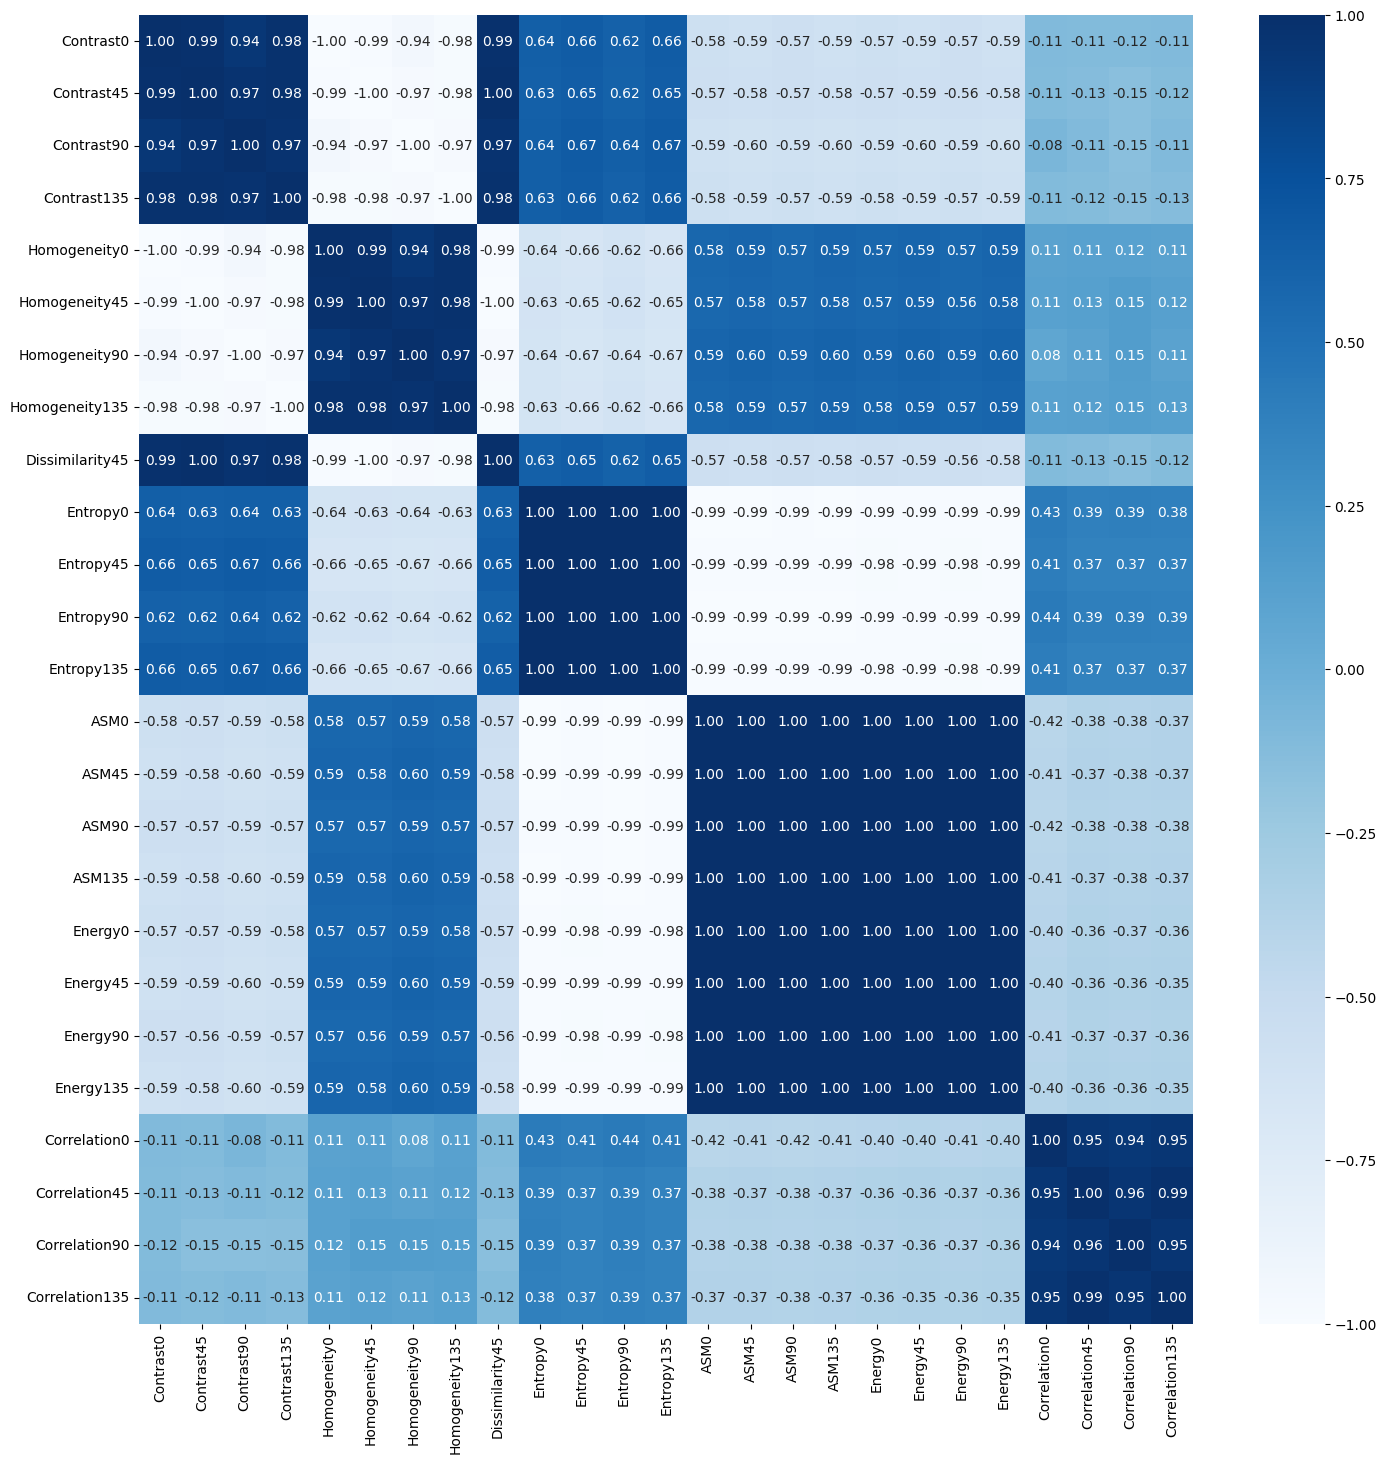

In [98]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 1 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### **Splitting Data**

In [99]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(519, 25)
(130, 25)


### **Feature Normalization**

berikut metode normalisasi yang bisa digunakan:

- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [100]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

### **Modeling**

#### **Define Model**

In [101]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

#### **Train Random Forest Classifier**

In [102]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      benign       0.95      0.97      0.96       282
   malignant       0.96      0.94      0.95       237

    accuracy                           0.96       519
   macro avg       0.96      0.95      0.96       519
weighted avg       0.96      0.96      0.96       519

[[273   9]
 [ 14 223]]
Accuracy: 0.9556840077071291

------Testing Set------
              precision    recall  f1-score   support

      benign       0.75      0.68      0.71        78
   malignant       0.58      0.65      0.61        52

    accuracy                           0.67       130
   macro avg       0.66      0.67      0.66       130
weighted avg       0.68      0.67      0.67       130

[[53 25]
 [18 34]]
Accuracy: 0.6692307692307692


#### **Train SVM Classifier**

In [103]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      benign       0.68      0.78      0.73       282
   malignant       0.69      0.57      0.62       237

    accuracy                           0.68       519
   macro avg       0.68      0.67      0.67       519
weighted avg       0.68      0.68      0.68       519

[[221  61]
 [103 134]]
Accuracy: 0.6840077071290944

------Testing Set------
              precision    recall  f1-score   support

      benign       0.74      0.73      0.74        78
   malignant       0.60      0.62      0.61        52

    accuracy                           0.68       130
   macro avg       0.67      0.67      0.67       130
weighted avg       0.69      0.68      0.69       130

[[57 21]
 [20 32]]
Accuracy: 0.6846153846153846


#### **Train KNN Classifier**

In [104]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      benign       0.79      0.82      0.81       282
   malignant       0.78      0.75      0.76       237

    accuracy                           0.79       519
   macro avg       0.79      0.78      0.78       519
weighted avg       0.79      0.79      0.79       519

[[231  51]
 [ 60 177]]
Accuracy: 0.7861271676300579

------Testing Set------
              precision    recall  f1-score   support

      benign       0.76      0.64      0.69        78
   malignant       0.56      0.69      0.62        52

    accuracy                           0.66       130
   macro avg       0.66      0.67      0.66       130
weighted avg       0.68      0.66      0.66       130

[[50 28]
 [16 36]]
Accuracy: 0.6615384615384615


### **Evaluation With Confusion Matrix**

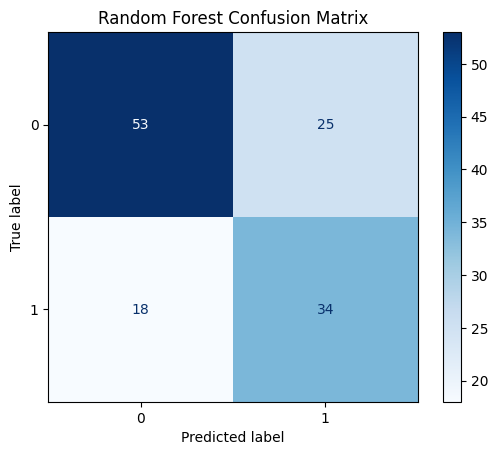

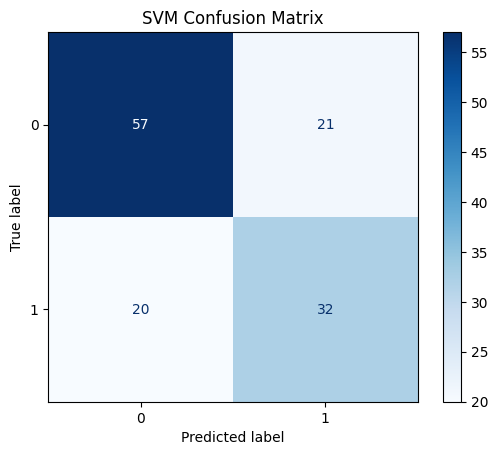

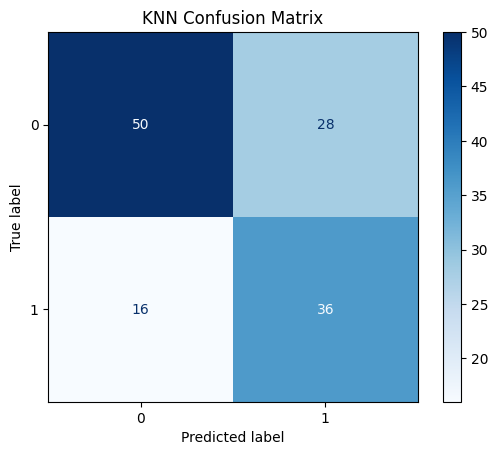

In [105]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")